In [2]:
%reset

import numpy as np
import pickle as pk

from astropy import units as u
from astropy import constants as const
# import matplotlib
from astropy.io import fits

import dill
# %pylab inline
import sys, os
# Color = ['#0072b1','#009d73','#d45e00','k', 'grey','yellow']
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/'
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/helper/')



Color = ['k', '#000075', '#a9a9a9','#9A6324', '#808000','#aaffc3', '#fffac8'  ,'#800000', '#ffd8b1',]

import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=True)
pl.rc('font', family='serif')

# %matplotlib inline




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [86]:
Pe_yx = np.load('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/save_Pe_yx.npz')

z_yx, M_yx, P_yx, r_yx, x_yx = Pe_yx['z'], Pe_yx['M_mat'], Pe_yx['Pe'], Pe_yx['rv'], Pe_yx['x']
ind_zyx = np.where(z_yx < 0.5)[0][-1]
ind_Myx = np.where(M_yx[0,:] < 5.0*10**14)[0][-1]
r_yx_ind = r_yx[ind_zyx, ind_Myx] * x_yx
P_yx_ind = P_yx[ind_zyx, ind_Myx,:]




In [87]:
from LSS_funcs import *

# nz = 20
# z_array_selum = np.linspace(0,2,nz)
# nm = 20
# M_array_block = np.logspace(10,15,nm)
k_array_block = np.logspace(-5,2,100)

z_array_selum = z_yx
nz = len(z_yx)
M_array_block = M_yx[0,:]
nm = len(M_array_block)


In [88]:
import colossus
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration
cosmo_colossus = cosmology.setCosmology('planck18')

conc_mat_dm = np.zeros((nz, nm))
for j in range(len(z_array_selum)):
    conc_mat_dm[j, :] = concentration.concentration(M_array_block, '200c', z_array_selum[j])  
    
rho_crit_array = cosmo_colossus.rho_c(z_array_selum) * (1000 ** 3)
M_mat_mdef = np.tile(M_array_block.reshape(1, nm), (nz, 1))
r_max_mat = get_R_from_M_mat(M_mat_mdef, 200 * rho_crit_array)    
ukz_mat = get_ukmz_g_kmat(r_max_mat, k_array_block, conc_mat_dm,1.)



In [89]:
from mcfit import xi2P
from mcfit import P2xi

H0 = 100. * (u.km / (u.s * u.Mpc))
G_new = const.G.to(u.Mpc ** 3 / ((u.s ** 2) * u.M_sun))
rho_crit = ((3 * (H0 ** 2) / (8 * np.pi * G_new)).to(u.M_sun / (u.Mpc ** 3))).value
rho_m = 2.775e11 * cosmo_colossus.Om0
# um_block_allinterp = RegularGridInterpolator(
    # (z_array_selum, np.log(M_array_block), np.log(k_array_block)),
    # np.log(um_block + 1e-200), fill_value=None, bounds_error=False)

coeff = (const.G * (const.M_sun ** 2) / ((1.0 * u.Mpc) ** 4)).to((u.eV / (u.cm ** 3))).value
coeff_si = (const.G * (const.M_sun ** 2) / ((1.0 * u.Mpc) ** 4)).value
nk = 200
k_array = np.logspace(-3,3,nk)
P_mat = np.zeros((len(z_array_selum), len(M_array_block), nk-1))
pressure_model_delta = 200
M_from_rho = np.zeros((len(z_array_selum), len(M_array_block)))
rhoM = np.zeros((len(z_array_selum), len(M_array_block),nk-1))
for jz in range(len(z_array_selum)):
#     print(jz)
    for jM in range(len(M_array_block)):
        ksel = np.where((k_array_block > 1e-4) & (k_array_block < 20))[0]
        um_interp = interpolate.interp1d(np.log(k_array_block[ksel]),np.log(ukz_mat[jz,ksel,jM]),fill_value='extrapolate')
        r_all, rho_M = P2xi(k_array)(np.exp(um_interp(np.log(k_array))))
        r_cent, rho_M_cent = 0.5*(r_all[1:] + r_all[:-1]), 0.5*(rho_M[1:] + rho_M[:-1])
        rho_cent = rho_M_cent * M_array_block[jM]
        rhoM[jz,jM,:] = rho_cent
        dr_all = r_all[1:] - r_all[:-1]
        int_M = 4*np.pi * (r_cent**2) * rho_cent * dr_all
        M_ltr = np.cumsum(int_M)
        to_int = -1 * G_new.value * M_ltr * (1./r_cent**2) * dr_all
        rhs_all = np.cumsum(to_int)
        gv = 1.25
        rho0 = rho_cent[0]
        rvir = np.power(3 * M_array_block[jM] / (4 * np.pi * 200. * rho_crit), 1. / 3.)
        rcv = np.where(r_cent > rvir)[0][0]
        M_from_rho[jz,jM] = M_ltr[rcv]
        
        P0 = 28.* (coeff / 2.) * pressure_model_delta * (
                0.044 / 0.3) * M_array_block[jM] * rho_crit / rvir
        P0_rho0 = 7.5*(0.044 / 0.3) * G_new.value * (M_array_block[jM] / rvir)
        rhs_mod = (1 + (1./P0_rho0) * ((gv-1)/gv) * rhs_all)**(gv/(gv-1))
        Pr_HSE = rhs_mod * P0
        P_mat[jz, jM, :] = Pr_HSE
        
        
P_hse_ind = P_mat[ind_zyx, ind_Myx,:]

        

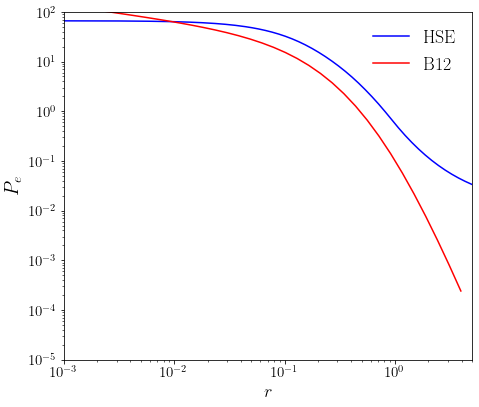

In [90]:
fig, ax = pl.subplots(1,1, figsize = (7,6))

ax.errorbar(r_cent,P_hse_ind,label=r'HSE',ls='-',marker='',elinewidth=2.0,color='blue')
ax.errorbar(r_yx_ind,P_yx_ind,label=r'B12',ls='-',marker='',elinewidth=2.0,color='red')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$P_e$', size = 20)
ax.set_ylim(1e-5,1e2)
ax.set_xlim(1e-3,5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()




In [ ]:
fig, ax = pl.subplots(1,1, figsize = (7,6))

ax.scatter(M_array_block,M_from_rho[0,:],marker='*',color='blue')
# ax.errorbar(r_yx_ind,P_yx_ind,label=r'B12',ls='-',marker='',elinewidth=2.0,color='red')
# ax.errorbar(pkmm_yx['M'],np.exp(Pk_cs_interp(np.log(pkmm_yx['M']))),label=r'Cosmosis',ls='-',marker='',elinewidth=2.0,color='red')

ax.set_xscale('log')
# ax.axhline(0,color='k',ls = '--')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$P_e$', size = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()



